# `pyEQL` Tutorial: Activity Coefficient Models

![pyEQL Logo](../../pyeql-logo.png)

`pyEQL` is an open-source `python` library for solution chemistry calculations and ion properties developed by the [Kingsbury Lab](https://www.kingsburylab.org/) at Princeton University.

[Documentation](https://pyeql.readthedocs.io/en/latest/) | [How to Install](https://pyeql.readthedocs.io/en/latest/installation.html) | [GitHub](https://github.com/KingsburyLab/pyEQL) 

This tutorial demonstrates different methods of calculating activity coefficients using `pyEQL`.

### Different modeling engines

When creating a `Solution`, you can use the `engine` keyword argument to specify which [Electrolyte Modeling Engine](https://pyeql.readthedocs.io/en/latest/engines.html#engines--page-root) you want to use.

- [`ideal`](https://pyeql.readthedocs.io/en/latest/engines.html#the-ideal-engine): Ideal solution model
- [`phreeqc`](https://pyeql.readthedocs.io/en/latest/engines.html#the-phreeqc-engine): Uses `phreeqpython` with `phreeqc.dat`
- [`native`](https://pyeql.readthedocs.io/en/latest/engines.html#the-native-engine-default) (default): Uses built-in Pitzer activity model (when available); falls back to other models if not

Below, we compare the predictions of the three different engines for 4 mol/kg NaCl.

In [41]:
from pyEQL import Solution

for engine in ["ideal", "phreeqc", "native"]:
    s1 = Solution({"Na+": "4 mol/kg", "Cl-": "4 mol/kg"}, engine=engine, pE=4)
    print(
        f"{engine:10}:  Na+ activity = {s1.get_activity('Na+').magnitude:.3f} Water activity = {s1.get_activity('H2O').magnitude:.3f} Conductivity = {s1.conductivity.to('mS/cm'):.~1f}"
    )

ideal     :  Na+ activity = 4.000 Water activity = 0.874 Conductivity = 221.7 mS / cm
phreeqc   :  Na+ activity = 4.497 Water activity = 0.874 Conductivity = 221.7 mS / cm
native    :  Na+ activity = 3.147 Water activity = 0.851 Conductivity = 204.9 mS / cm


### Comparing Activity Coefficient Models

`pyEQL` contains built-in implementations of a variety of activity coefficient models. The links below will take you to the associated documentation page for each:

- [Debye-Huckel equation](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.activity_correction.get_activity_coefficient_debyehuckel) (valid for `I<0.005` mol/kg)
- [GUntelberg Equation](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.activity_correction.get_activity_coefficient_guntelberg) (valid for `I<0.1` mol/kg)
- [Davies Equation](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.activity_correction.get_activity_coefficient_davies) (valid for `I<0.5` mol/kg)
- [Pitzer Model](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.activity_correction.get_activity_coefficient_pitzer) (valid for all concentrations)

**NOTE:** `pyEQL`'s default modeling engine automatically selects among these models to use the best available (e.g., use Pitzer if adequate parameters are available in the database, otherwise fall back to Davies, Guntelberg, or Debye-Huckel depending on the ionic strength). As a user, all you have to do is call [`Solution.get_activity_coefficient(<solute>)`](https://pyeql.readthedocs.io/en/latest/class_solution.html#pyEQL.Solution.get_activity_coefficient). However, in this example, we will explicitly import the underlying methods (e.g., [`get_activity_coefficient_debyehuckel`](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.activity_correction.get_activity_coefficient_debyehuckel)) so we can compare them directly. See [documentation of the `native` modeling engine for details](https://pyeql.readthedocs.io/en/latest/internal.html#pyEQL.engines.NativeEOS.get_activity_coefficient).

In [28]:
from pyEQL.activity_correction import (
    get_activity_coefficient_debyehuckel,
    get_activity_coefficient_davies,
    get_activity_coefficient_guntelberg,
)

# experimental data for NaCl activity coefficient, obtained from the IDST
# https://idst.inl.gov
idst_mol = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
idst_gamma = [
    0.7813,
    0.7376,
    0.713,
    0.6966,
    0.6852,
    0.6767,
    0.6707,
    0.6662,
    0.6628,
    0.6605,
    0.6509,
    0.6575,
    0.6589,
    0.6621,
    0.6673,
    0.6864,
    0.7129,
    0.7459,
    0.7854,
    0.8316,
    0.8839,
    0.9423,
    1.0067,
]

# we'll save results from each model in these lists
gamma_debyehuckel = []
gamma_guntelberg = []
gamma_davies = []
gamma_pitzer = []

for conc in idst_mol:
    s1 = Solution({"Na+": f"{conc} mol/kg", "Cl-": f"{conc} mol/kg"})
    gamma_debyehuckel.append(get_activity_coefficient_debyehuckel(s1.ionic_strength, 1, str(s1.temperature)))
    gamma_guntelberg.append(get_activity_coefficient_guntelberg(s1.ionic_strength, 1, str(s1.temperature)))
    gamma_davies.append(get_activity_coefficient_davies(s1.ionic_strength, 1, str(s1.temperature)))
    gamma_pitzer.append(s1.get_activity_coefficient("Na+"))

Text(0.5, 0.98, 'pyEQL prediction of NaCl activity coefficient')

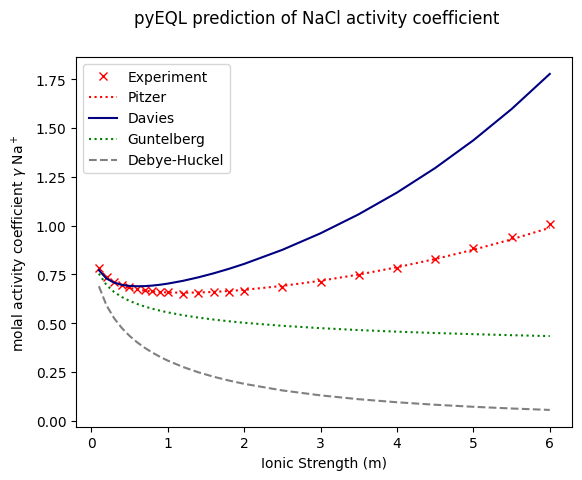

In [37]:
# plot the results!
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(idst_mol, idst_gamma, label="Experiment", ls="", color="red", marker="x")
ax.plot(idst_mol, gamma_pitzer, label="Pitzer", ls=":", color="red")
ax.plot(idst_mol, gamma_davies, label="Davies", ls="-", color="navy")
ax.plot(idst_mol, gamma_guntelberg, label="Guntelberg", ls=":", color="green")
ax.plot(idst_mol, gamma_debyehuckel, label="Debye-Huckel", ls="--", color="gray")

ax.legend()
ax.set_xlabel("Ionic Strength (m)")
ax.set_ylabel("molal activity coefficient $\\gamma$ Na$^+$")
fig.suptitle("pyEQL prediction of NaCl activity coefficient")

### Activity coefficient on different scales

You can pass a `scale` keyword argument to [`Solution.get_activity`](https://pyeql.readthedocs.io/en/latest/class_solution.html#pyEQL.Solution.get_activity) or [`Solution.get_activity_coefficient`](https://pyeql.readthedocs.io/en/latest/class_solution.html#pyEQL.Solution.get_activity_coefficient) to obtain the activity coefficient on different scales. Valid options are

- `molal` (default)
- `molar` i.e., mol/L
- `rational`, appropriate for use with mole fractions

In [43]:
s1 = Solution({"Na+": "4 mol/kg", "Cl-": "4 mol/kg"}, engine=engine, pE=4)
print(
    f"gamma_molal    = {s1.get_activity_coefficient('Na+', scale='molal'):~.3f}\n"
    f"gamma_molar    = {s1.get_activity_coefficient('Na+', scale='molar'):~.3f}\n"
    f"gamma_rational = {s1.get_activity_coefficient('Na+', scale='rational'):~.3f}"
)

gamma_molal    = 0.787
gamma_molar    = 0.851
gamma_rational = 0.900


In [44]:
s1 = Solution({"Na+": "4 mol/kg", "Cl-": "4 mol/kg"}, engine=engine, pE=4)
print(
    f"molal scale activity:    = {s1.get_activity('Na+', scale='molal'):.~3f}\n"
    f"molar scale activity:    = {s1.get_activity('Na+', scale='molar'):.~3f}\n"
    f"rational scale activity: = {s1.get_activity('Na+', scale='rational'):.~3f}"
)

molal scale activity:    = 3.147
molar scale activity:    = 3.138
rational scale activity: = 0.057
